## Tweets Sentiment Analysis

In this tutorial, we will create a Twitter messages Sentiment analysis by classifying text using DistilBERT. Sentiment analysis identifies the polarity of given text. DistilBert has 40% less parameters than Bert-base-uncased, and runs 60% faster while preserving over 95% of BERT's performances.

## The Dataset

To start with, we need to select a dataset. Here we will use the Emotions dataset. It is an English Twitter messages dataset classified into 6 basic emotions: sad, anger, fear, joy, love. We download the data from Hugging Face Hub using Datasets.

In [ ]:
!pip install transformers --quiet
!pip install datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.6 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

In [ ]:
emotions = load_dataset('emotion')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

The emotions dataset has a similar structure to a Python dictionary therefore similar operations apply here

In [ ]:
emotions

In [ ]:
imbd

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 50000
    })
})

### Visualisation of the Dataset

The dataset is converted to a pandas DataFrame to


*   Allow use of APIs for data visualisation
*   Easily inspect data e.g. using *head()*, *describe()*

To achieve this a simple to use *set_format()* method is available



In [ ]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

In [ ]:
imbd.set_format(type='pandas')
df = imbd['train'][:]
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


The label column shows integers and can be transformed to string with the actual emotion using *int2str()* method to create a new column 'label_name'

In [ ]:
def label_int2str(row):
  return emotions['train'].features['label'].int2str(row)

In [ ]:
df['label_name'] = df['label'].apply(label_int2str)
df.head()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes')
plt.show()

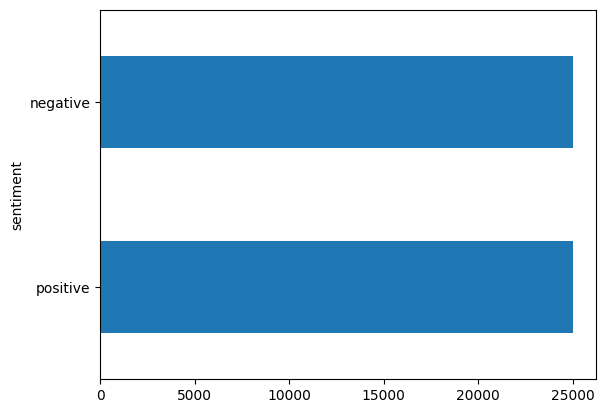

In [ ]:
df['sentiment'].value_counts(ascending=True).plot.barh()
plt.show()

The dataset is not balanced. To deal with unbalanced data one can


*   randomly oversample the minority class
* randomly undersample the majority class
* gather more data

However in this project, I will work with the data as is!


### Maximum Context Size

Transformer models have a maximum input sequence length and for DistillBert it is 512 tokens. Anything above this needs to be cutoff leading to loss of information

In [ ]:
df.columns

In [ ]:
df[]

In [ ]:
df['Words per tweet'] = df['text'].str.split().apply(len)
df.head()

In [ ]:
df.boxplot('Words per tweet', by='label_name', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

Most of the twitter messages throughout the six emotions have length around 15 so all the information will be preserved

In [ ]:
emotions.reset_format()

### Tokenization

Breaking down text into atomic units used in the model

In [ ]:
from transformers import AutoTokenizer

In [ ]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [ ]:
emotions_encoded['train'].column_names

## Training a Classifier

### Transformers as feature extractors

- Freeze the body weights during training
- Use the hidden states as feature the classifier

Quickly train a small model
Good for resource constrained devices
Low accuracy


In [ ]:
!pip install torch --quiet

### Retrieving last hidden state of string

In [ ]:
text = 'I love machine learning always'
inputs = tokenizer(text, return_tensors='pt')
print(f"Input tensor shape: {inputs['input_ids'].size()}")

In [ ]:
inputs.items()

In [ ]:
for k,v in inputs.items():
  print(k,v)

In [ ]:
from transformers import AutoModel
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [ ]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items()
  if k in tokenizer.model_input_names}

  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}

In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask" , "label"])

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [ ]:
emotions_hidden['train'].column_names

### Creating a feature matrix

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

#### Visualizing the training set

In [ ]:
!pip install umap-learn

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=['X' , 'Y'])
df_emb['label'] = y_train
df_emb.head()

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(7,5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels,cmaps)):
  df_emb_sub = df_emb.query(f'label == {i}')
  axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true,labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Normalized confusion matrix')
  plt.show()

In [ ]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid,labels)

### **Method 2**: Finetuning transformers

In this method, we will finetune a transformer end to end

#### Load the pretrained model

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'f1':f1}

#### Training the model

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded['train'])//batch_size
model_name = (f'{model_ckpt}-finetuned-emotion')
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_eval_batch_size=batch_size,
                                  per_device_train_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level='error'
                                  )

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer
                  )

trainer.train();

In [ ]:
preds_output = trainer.predict(emotions_encoded['validation'])

In [ ]:
preds_output.metrics

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
from transformers import pipeline

model_id = 'Charmainemahachi/distilbert-base-uncased-finetuned-emotion'
classifier = pipeline('text-classification', model=model_id)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
custom_tweet = 'Today I am very excited'
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df['score'])
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

NameError: name 'pd' is not defined

In [ ]:
preds_df

In [ ]:
preds

[[{'label': 'LABEL_0', 'score': 0.00015380560944322497},
  {'label': 'LABEL_1', 'score': 0.9991224408149719},
  {'label': 'LABEL_2', 'score': 0.00013993761967867613},
  {'label': 'LABEL_3', 'score': 0.00022311140492092818},
  {'label': 'LABEL_4', 'score': 0.0001770793169271201},
  {'label': 'LABEL_5', 'score': 0.00018370940233580768}]]

In [ ]:
labels = emotions['train'].features['label'].names

In [ ]:
# Get the prediction with highest score
max_pred = max(preds[0], key=lambda x: x['score'])

# Get the corresponding label
label_index = int(max_pred['label'].split('_')[1])
predicted_label = labels[label_index]

print(f"Predicted emotion: {predicted_label} with score: {max_pred['score']}")

Predicted emotion: joy with score: 0.9991224408149719


In [ ]:
def classify(text):
  preds = classifier(text, return_all_scores=True)
  max_pred = max(preds[0], key=lambda x: x['score'])
  label_index = int(max_pred['label'].split('_')[1])
  predicted_label = labels[label_index]
  print(f"Predicted emotion: {predicted_label} with score: {max_pred['score']}")

  return f"{predicted_label}, {max_pred['score']*100 :.2f}%"

In [ ]:
classify('i am sad tofay today?')

Predicted emotion: sadness with score: 0.9558920860290527


/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


'sadness, 95.59%'

In [ ]:
!pip install gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.3 MB/s eta 0:00:00


In [ ]:
import gradio as gr

demo = gr.Interface(fn=classify, inputs='textbox', outputs='textbox')

if __name__ == "__main__":
  demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9697231755e33bf614.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
